In [87]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Modelling LFC results

Attempt to build a model to predict the result of a liverpool game

### Load fixture history data

In [88]:
file_path = os.path.join(os.path.pardir, 'data', 'liverpool_fixture_history.csv')
df = pd.read_csv(file_path)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(5)

,away_score,competition,date,home_score,nth_game_this_season,opposition,venue
0,1,1st Division,1991-08-17,2,1,Oldham Athletic,Anfield
1,2,1st Division,1991-08-21,1,2,Manchester City,Maine Road
2,0,1st Division,1991-08-24,0,3,Luton Town,Kenilworth Road
3,0,1st Division,1991-08-27,1,4,Queens Park Rangers,Anfield
4,1,1st Division,1991-08-31,3,5,Everton,Anfield


### Create some booleans on the results and locations

In [89]:
# Location. Extract whether it was a home game or not then lose the venue as its unlikely we can learn anything
# that we can't get from home/away and the opposition
df['liverpool_at_home'] = df['venue'] == 'Anfield'
df.drop('venue', axis=1, inplace=True)

df['result'] = 0

# Win
df.loc[(df['liverpool_at_home'] & (df['home_score'] > df['away_score'])) | \
       (~df['liverpool_at_home'] & (df['home_score'] < df['away_score'])), 'result'] = 1

# Draw
df.loc[df['home_score'] == df['away_score'], 'result'] = 0

# Loss
df.loc[(~df['liverpool_at_home'] & (df['home_score'] > df['away_score'])) | \
       (df['liverpool_at_home'] & (df['home_score'] < df['away_score'])), 'result'] = 2

# Win / Not win binary flag
df['win_flag'] = df['result'] == 1
df['loss_flag'] = df['result'] == 2

# Convert the date to datetime off the bat
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')  # Convert to a datetime

In [90]:
print('Liverpool\'s overall win rate: \t {:.2f}%'.format(100*np.mean(df['result'] == 1)))
print('Liverpool\'s overall draw rate: \t {:.2f}%'.format(100*np.mean(df['result'] == 0)))
print('Liverpool\'s overall loss rate: \t {:.2f}%'.format(100*np.mean(df['result'] == 2)))

Liverpool's overall win rate: 	 46.32%
Liverpool's overall draw rate: 	 25.06%
Liverpool's overall loss rate: 	 28.62%


## Feature extraction

Dataset is fairly simple at the moment but contains more than it seems. Lets pull out some hopefully useful info.

### Performance vs particular opponents

Firstly, build some metrics to quantify how well Liverpool usually play against each opposition. This fairly dependent on time, so lets only look at the last 5 years.

In [91]:
# Trim data to the last 5 years
years_to_consider = 5
time_cutoff = pd.to_datetime('today') - pd.Timedelta(weeks=52*years_to_consider)
temp_df = df[df['date'] > time_cutoff]

In [92]:
# Loop through each team and calculate general performance
unique_opponents = temp_df['opposition'].unique()
win_proportion = []
loss_proportion = []
times_played = []

for team in unique_opponents:
    win_proportion.append(temp_df.loc[temp_df['opposition'] == team, 'win_flag'].mean())
    loss_proportion.append(temp_df.loc[temp_df['opposition'] == team, 'loss_flag'].mean())
    times_played.append(sum(temp_df['opposition'] == team))
    
opposition_performance = pd.DataFrame({'opposition': unique_opponents,
                                       'win_proportion': win_proportion,
                                       'loss_proportion': loss_proportion,
                                       'times_played': times_played})
opposition_performance['performance_metric'] = opposition_performance['win_proportion'] - \
                                               opposition_performance['loss_proportion']
    
# Merge results back into original df
df = df.merge(opposition_performance, left_on='opposition', right_on='opposition', how='left')

# Drop columns used in metric calculation. Not crucial but want to keep in streamlined
df.drop(['times_played', 'win_proportion', 'loss_proportion'], axis=1, inplace=True)
del temp_df

Then for any team played over a couple times, who's the best and worst?

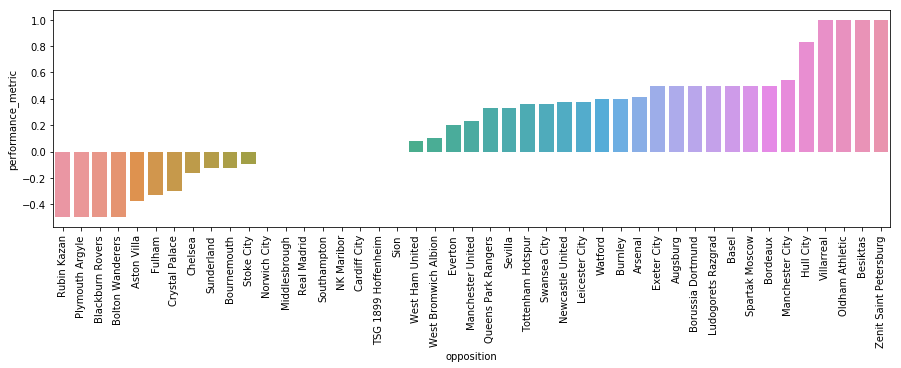

In [93]:
regulars = opposition_performance[['opposition', 'performance_metric']] \
           .where(opposition_performance['times_played'] >= 2).dropna()
regulars.sort_values(by='performance_metric' ,inplace=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,4])
sns.barplot(ax=ax, data=regulars, x='opposition', y='performance_metric')
for item in ax.get_xticklabels():
    item.set_rotation(90)

Suprisingly good against the Manchester teams...

### Encode oppostition

Any ML model we use won't want the opposition as a string

In [94]:
from sklearn.preprocessing import LabelEncoder

# Opposition encoder
opposition_encoder = LabelEncoder()
df['opposition'] = opposition_encoder.fit_transform(df['opposition'])

### Feature engineering

#### Date related features
What can we learn from the date of the match?

In [95]:
# Extract info from date
df['day_of_week'] = df['date'].dt.weekday.astype(int)  # Record day of week

# Order by date and get days since last game
df.sort_values(by='date', ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)

for i in range(len(df) - 1):
    df.loc[i, 'days_since_last_game'] = df.loc[i, 'date'] - df.loc[i + 1, 'date']
df['days_since_last_game'].fillna(df['days_since_last_game'].median(), inplace=True)
df['days_since_last_game'] = df['days_since_last_game'].dt.days.astype(int)

# Cap days since last game to 10
df.loc[df['days_since_last_game'] > 10, 'days_since_last_game'] = 10

In [96]:
# Convert date into a weighting for the training data
df['date'] = pd.to_datetime('today') - df['date']  # Convert to difference from today
df['date'] = df['date'].dt.days.astype(float)  # Convert to an integer

scaler = MinMaxScaler(feature_range=(0,1))
df['date'] = scaler.fit_transform(df['date'].values.reshape(-1, 1))

# Invert so the older values get less weight
df['date'] = 1 - df['date']

#### Liverpool related features

Loop through data set and generate win streaks etc.

In [97]:
# Reset the index so we can loop down in time
df.reset_index(drop=True, inplace=True)

# Initialise a win streak feature
df['win_streak'] = 0
df['undefeated_streak'] = 0

for i in range(len(df) - 1):
    
    # Initialise streak counters
    win_streak = 0
    undefeated_streak = 0
    
    # Was the most recent game a win?
    won_last_game = bool(df.loc[i + 1, 'result'] == 1)
                         
    # Not a loss?
    undefeated_last_game = bool((df.loc[i + 1, 'result'] == 1) | (df.loc[i + 1, 'result'] == 0))
    
    # Keep going back until we break the win streak
    while won_last_game:
        win_streak += 1
        index = i + 1 + win_streak
        if index < len(df):
            won_last_game = bool(df.loc[index, 'result'] == 1)
        else:
            break
    
    # Keep going back until we break the undefeated streak
    while undefeated_last_game:
        undefeated_streak += 1
        index_undef = i + 1 + undefeated_streak
        if index_undef < len(df):
            undefeated_last_game = bool((df.loc[index_undef, 'result'] == 1) | (df.loc[index_undef, 'result'] == 0))
        else:
            break
        
    # Save the result
    df.loc[i, 'win_streak'] = win_streak
    df.loc[i, 'undefeated_streak'] = undefeated_streak

#### Opposition related features

In [98]:
# Add the number of times the two teams have played each other in this data set
opposition_count_dict = dict(df['opposition'].value_counts())
df['n_times_teams_played'] = df['opposition'].map(opposition_count_dict)

### Drop data that we can't use in training

In [99]:
# Only interested in the Premier League for now
df = df[df['competition'] == 'Premier League']
df.drop('competition', axis=1, inplace=True)

In [100]:
# Scores can't be used in prediction
df.drop(['away_score', 'home_score'], axis=1, inplace=True)

### Visualise behaviour of final feature space

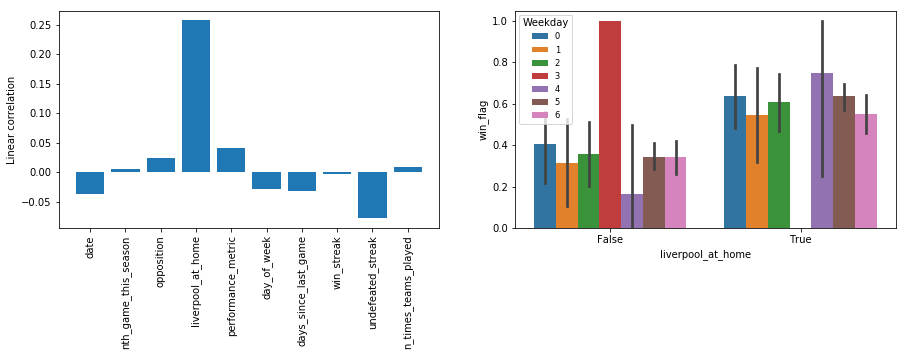

In [101]:
# Calculate correlation matrix then extract the correlations with respect to the win flag
corr_mat = df.corr()
correlation_with_win = corr_mat['win_flag']
correlation_with_win = correlation_with_win[~np.isin(correlation_with_win.index.values, 
                                                     ['win_flag', 'result', 'loss_flag'])]

# Plot these correlations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,4])
ax[0].bar(height=correlation_with_win, x=np.arange(len(correlation_with_win)))
ax[0].set_xticks(np.arange(len(correlation_with_win)))
ax[0].set_xticklabels(correlation_with_win.index.values, rotation=90)
ax[0].set_ylabel('Linear correlation')

# Plot a bar chart to see how home advantage and day of week affect the win rate
sns.barplot(data=df, x='liverpool_at_home', y='win_flag', hue='day_of_week', ax=ax[1])
ax[1].legend(loc=2, title='Weekday', fontsize='small')
plt.show()

So home advantage has the strongest linear relationship by a way, and appears to be most important on Fridays! (`weekday = 4`)

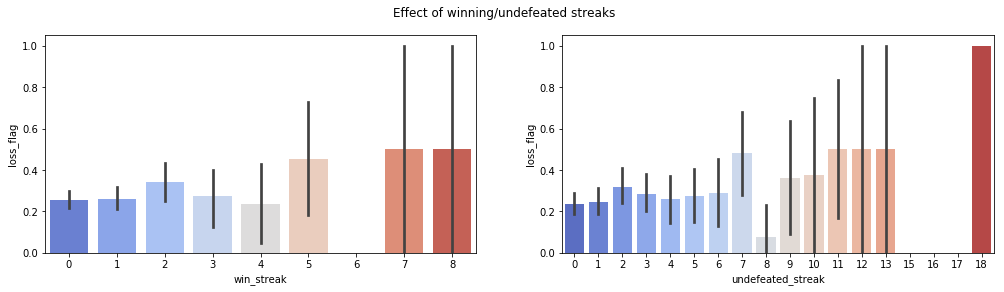

In [102]:
# Plot the streaks
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[17,4])
sns.barplot(data=df, x='win_streak', y='loss_flag', ax=ax[0], palette='coolwarm')
sns.barplot(data=df, x='undefeated_streak', y='loss_flag', ax=ax[1], palette='coolwarm')
plt.suptitle('Effect of winning/undefeated streaks')
plt.show()

In [103]:
# Also drop the win_flag after its been used for visualsiation
df.drop(['win_flag', 'loss_flag'], axis=1, inplace=True)

### Create a stratified test set

In [104]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df.reset_index(inplace=True, drop=True)
for train_index, test_index in split.split(df, df['result']):
    train = df.loc[train_index]
    test = df.loc[test_index]

In [105]:
sample_comparison = pd.DataFrame({
    'overall': df['result'].value_counts().sort_index() / len(df),
    'stratified': test['result'].value_counts().sort_index() / len(test),
    })
sample_comparison['strat. % error'] = 100 * (sample_comparison['stratified'] - sample_comparison['overall']) \
                                     / sample_comparison['overall']
sample_comparison

,overall,stratified,strat. % error
0,0.252772,0.254144,0.542793
1,0.476718,0.475138,-0.331492
2,0.270510,0.270718,0.076986


In [106]:
# Separate the labels
y_train = train.pop('result')
y_test = test.pop('result')

# Drop dates, but keep the training dates as a weight
train_weight = train.pop('date')
test.drop('date', axis=1, inplace=True)

### Build a model

In [107]:
train['performance_metric'].fillna(0, inplace=True)
test['performance_metric'].fillna(0, inplace=True)

In [232]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)

In [233]:
import lightgbm as lgbm

# Create a training set
categoricals = ['opposition', 'liverpool_at_home', 'day_of_week']
lgbm_train_set = lgbm.Dataset(data=train, label=y_train, 
                              categorical_feature=categoricals, 
                              weight=train_weight,
                              free_raw_data=False)

# Set the training parameters
lgbm_params = {'application': 'multiclass',
               'booting': 'gbdt',
               'metric': 'multi_logloss',
               'training_metric': True,
               'learning_rate': 0.05,
               'feature_fraction': 0.8,
               'min_data_in_leaf': 30,
               'num_leaves': 31,
               'num_classes': 3}

In [248]:
cv_results = lgbm.cv(train_set=lgbm_train_set, 
                     params=lgbm_params, 
                     nfold=5, 
                     verbose_eval=0, 
                     num_boost_round=100,
                     early_stopping_rounds=10)
best_iteration = len(cv_results['multi_logloss-mean'])
print(cv_results['multi_logloss-mean'][-1])

/Users/sylviashepherd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


1.01528459801


In [235]:
clf = lgbm.train(train_set=lgbm_train_set, 
                 params=lgbm_params,
                 num_boost_round=best_iteration)

/Users/sylviashepherd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [236]:
y_prob = clf.predict(test, num_iteration=best_iteration)
y_pred = y_prob.argmax(axis=1)

LGBM classification accuracy =  	 50.83%


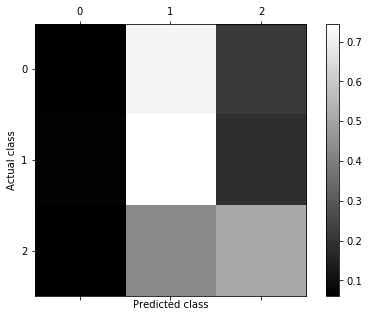

In [246]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

# Simple accuracy score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
print("LGBM classification accuracy =  \t {:.2f}%".format(100*accuracy))

# Visualise the confusion matrix, normalised for classification frequency
conf_matrix = confusion_matrix(y_test, y_pred)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
# np.fill_diagonal(norm_conf_matrix, 0)

fig, ax = plt.subplots(figsize=[7,5])
conf_plot = ax.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.colorbar(ax=ax, mappable=conf_plot)
plt.show()

In [247]:
print(precision)
print(recall)

[ 0.25        0.54237288  0.49019608]
[ 0.06521739  0.74418605  0.51020408]


Lighter colors represent larger numbers in that position, so in this case we can see a lot of the errors are coming from draws (actual = 0) predicted to be wins (prediction = 1) in the centre-top position.

Second worst are losses predicted to be wins. This strongly indicates that winning predictions are the most wrong.

Sound like Liverpool?!

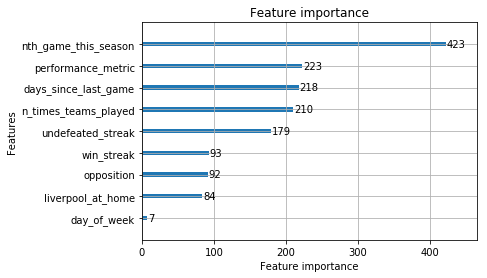

In [219]:
lgbm.plot_importance(clf)

### Predict a given game

In [220]:
train.head(1)

,nth_game_this_season,opposition,liverpool_at_home,performance_metric,day_of_week,days_since_last_game,win_streak,undefeated_streak,n_times_teams_played
749,43,6,False,0.416667,0,4,1,7,61


In [221]:
# Upcoming game info
pred_game_date = '2017-12-30'
pred_game_opp = 'Leicester City'
liverpool_at_home = True
game_number_this_season = 26
days_since_last_game = 4
curr_win_streak = 1
curr_undefeated_streak = 5 

In [222]:
given_opp = opposition_encoder.transform([pred_game_opp])
given_opp[0]

72

In [223]:
given_opp_times_played = opposition_count_dict[given_opp[0]]
given_opp_times_played

22

In [224]:
pred_perf_metric = \
    opposition_performance.loc[opposition_performance['opposition'] == pred_game_opp, 'performance_metric'].values
pred_perf_metric[0]

0.375

In [225]:
pred_game = np.array([
    game_number_this_season,
    given_opp[0],
    liverpool_at_home,
    pred_perf_metric[0],
    pd.to_datetime(pred_game_date, format='%Y-%m-%d').weekday(),
    days_since_last_game,
    curr_win_streak,
    curr_undefeated_streak,
    given_opp_times_played
], dtype='O').reshape([1, len(train.columns)])

In [226]:
y_prob_live = clf.predict(pred_game)
y_pred_live = y_prob_live.argmax(axis=1)
y_prob_live_log = log_clf.predict_proba(pred_game)

In [227]:
print('Win probability: \t {:.2f}%'.format(100*y_prob_live[0][1]))
print('Loss probability: \t {:.2f}%'.format(100*y_prob_live[0][2]))
print('Draw probability: \t {:.2f}%'.format(100*y_prob_live[0][0]))

Win probability: 	 59.73%
Loss probability: 	 17.54%
Draw probability: 	 22.73%


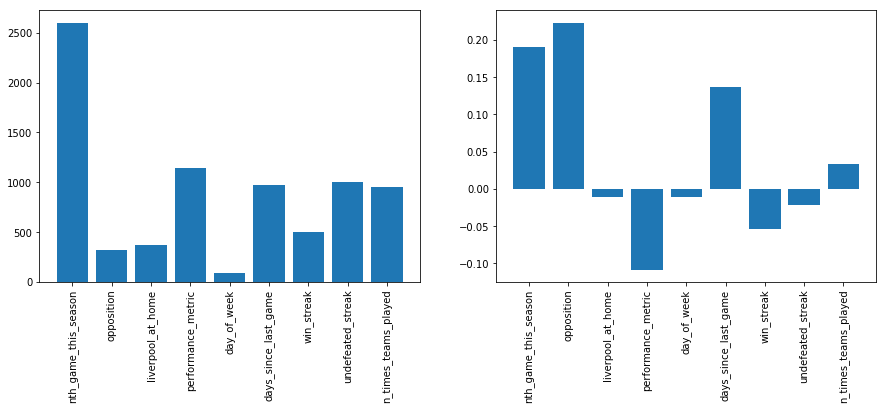

In [35]:
feature_contributions = clf.predict(pred_game, pred_contrib=True)
ind = np.arange(len(clf.feature_importance()))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
ax[0].bar(height=clf.feature_importance(), x=ind)
ax[1].bar(height=feature_contributions.ravel()[:-1], x=ind)
for axs in ax:
    axs.set_xticks(np.arange(len(clf.feature_importance())))
    axs.set_xticklabels(clf.feature_name(), rotation=90)
plt.show()